In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fft, fftfreq, fftshift, ifft2, fft2
from scipy import signal
from scipy.io import wavfile
import sklearn
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
# Загрузка экспериментальных данных и используемые методы
sample_rate, audio_data49_3 = wavfile.read('/Users/bogda/Documents/NFS/ Научка/Исходные данные/ExpSummer2024/TASCAM_Files/TASCAM_0049S3.wav')
sample_rate, audio_data49_2 = wavfile.read('/Users/bogda/Documents/NFS/ Научка/Исходные данные/ExpSummer2024/TASCAM_Files/TASCAM_0049S2.wav')
df = pd.read_excel('/Users/bogda/Desktop/Acoustics/Scientific/Таблицы Данных/Conducting an experiment 30_08.xlsx')

print(f"Частота дискретизации: {sample_rate} Гц")
print(f"Форма массива данных: {audio_data49_3.shape}")
print(audio_data49_3)

def plot1 (X1, Y1, name):
    plt.figure(figsize=(10,4))
    plt.plot(X1, Y1, color='blue')
    plt.ylabel('Амплитуда, у.е.')
    plt.title(name)
    plt.grid(True)
    plt.show()
    
def plot1_f (X1, Y1, name, freq_filt:int):
    plt.figure(figsize=(10,4))
    plt.plot(X1, Y1, color='blue')
    plt.ylabel('Амплитуда, у.е.')
    plt.title(name)
    plt.grid(True)
    plt.xlim(-freq_filt,freq_filt)
    plt.show()   
    
def plot2 (Y1, X1, Y2, X2):
    
    plt.plot(X2, Y2, color='red')
    plt.plot(X1, Y1, color='blue')
    plt.legend()
    plt.grid(True)
    plt.show()

def corr_t(data1, data2):
    mn=min([len(data1), len(data2)])
    data1 = data1[0:mn]
    data2 = data2[0:mn]
    data1_f = ifft(data1)
    data2_f = ifft(data2)
    return np.fft.fftshift(fft(data1_f*np.conj(data2_f)))

def corr_f(data1, data2, f1):
    mn = min(len(data1), len(data2))
    data1_f = ifft(data1)
    data2_f = ifft(data2)
    s1 = np.zeros(mn)
    s2 = np.zeros(mn)
    f = fftfreq(mn, 1 / sample_rate)

    for i in range (0, mn):
        if f[i] > -f1:
            if f[i] < f1:
                s1[i] = data1_f[i]
                s2[i] = data2_f[i]

    fft_abs_s1 = fft((np.abs(s1))**2)
    fft_abs_s2 = fft((np.abs(s2))**2)
    
    corr_f = ifft((fft_abs_s1)*np.conj(fft_abs_s2))
    return corr_f


def count_time(first, df):
    cf_time = '15:26:16'
    cd_time = str(df.loc[first, 'Start time'])
    dur_time = str((df.loc[first, 'Duration']))
    c_time_dt = datetime.strptime(cf_time, "%H:%M:%S")
    x_time_dt = datetime.strptime(cd_time, "%H:%M:%S")
    duration = datetime.strptime(dur_time, "%H:%M:%S")

    # print(type(x_time_dt))
    delta = (x_time_dt -  c_time_dt).seconds%86400
    time_b_1 = delta
    duration_sec = duration.hour*3600 + duration.minute*60 + duration.second
    print(duration_sec)
    time_b_2 = delta + duration_sec
    return time_b_1, time_b_2, duration_sec


def cr_arr_t(first):
    t1_beg, t1_end, duration = count_time(first, df)
    t_int1 = (t > t1_beg) & (t <= t1_end)
    t1 = t[t_int1]
    f1 = fftfreq(int(len(t1)), 1 / sample_rate) # Массив частот
    
    array = [t_int1, t1, f1, duration]
    return array


def norm_max (data):
    return data/max(data)


def load_mat(data_1_str: str):
    dataset = loadmat(data_1_str)
    dat = [[element for element in upperElement] for upperElement in dataset['dataa']]
    data=[]
    
    for i in range (0,len(dat[0])):
        data.append(dat[0][i])

    if len(dat[0])%2==1:
        data=data[:len(dat[0])-1]

    return data


def first_second_part(data):
    data_first = []
    data_second = []
    for i in range(0,int(len(data)/2)):
        data_first.append(data[i])
    
    for i in range(int(len(data)/2),int(len(data))):
        data_second.append(data[i])

    return data_first, data_second


def S_N_f (data1, data2):
    
    mn = min(len(data1), len(data2))
    data1 = data1[:mn]
    data2 = data2[:mn]
    data1 = np.abs(ifft(data1))
    data2 = np.abs(ifft(data2))

    data12 = np.sum(data1*data2)
    norm1 = np.sum(data1**2)
    norm2 = np.sum(data2**2)
    data_norm12 = np.sqrt(norm1)*np.sqrt(norm2)
    if data_norm12 == 0 :
        print('На ноль не делим')
    SN = data12/data_norm12
    return SN


def t_central(t, sample_rate):
    t_c = t - len(t)/sample_rate/2
    return t_c


def t_arr_for_corr_t(data):
    l = len(data)
    t = np.arange(l)/sample_rate
    t = t_central(t, sample_rate)
    return t

t = np.arange(int(len(audio_data49_3)))/sample_rate # Массив времен

In [52]:
# Создание массивов, используемых в обработке
t_f_arr_1 = cr_arr_t(44)
t_f_arr_2 = cr_arr_t(47)
audio_data49_3_1 = audio_data49_3[t_f_arr_1[0]]
audio_data49_3_2 = audio_data49_3[t_f_arr_2[0]]
audio_data49_2_1 = audio_data49_2[t_f_arr_1[0]]

min_len_1 = min(len(audio_data49_3_1),len(audio_data49_2_1))

5
720


In [ ]:
# Графики исследований
plt.plot(t_f_arr_1[1], audio_data49_3_1, color='brown', label='Small')
plt.show()

plt.plot(t_f_arr_1[1], audio_data49_2_1, color='blue', label='Small')
plt.show()

In [ ]:
plt.plot(t_f_arr_1[2], np.abs(ifft(audio_data49_3_1)))
plt.title('Портрет DJI MATRICE 300 RTK')
plt.grid(True)
plt.xlim(-600, 600)
plt.legend()
plt.show

In [ ]:
corr_t_2_micr = corr_t(audio_data49_2_1, audio_data49_3_1)
t_c = t_arr_for_corr_t(corr_t_2_micr)
plt.plot(t_c, np.abs(corr_t_2_micr))
plt.grid(True)
plt.title('Временная корреляция с 2 микрофонов, при пролете около них')
plt.legend()
plt.show

In [54]:
S_N_arr = []
for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
    a = S_N_f(audio_data49_3_1, audiodata2_sec)
    S_N_arr.append(a)
    


In [41]:
S_N_f(audio_data49_3_1, audio_data49_3_2)

0.3955814529114433

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

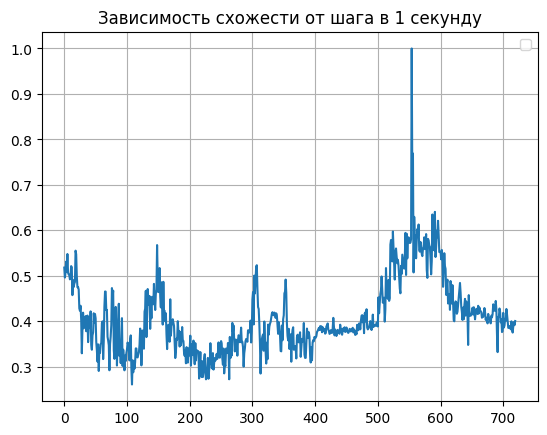

In [55]:
n = np.arange(int(len(t_f_arr_2[1])/sample_rate))
plt.plot(n, S_N_arr)
plt.title('Зависимость схожести от шага в 1 секунду')
plt.grid(True)
plt.legend()
plt.show
plt.show

In [ ]:
data1_0db = load_mat('/Users/bogda/Documents/NFS/ Научка/Исходные данные/Matlab_Files/2023.03.31-11.59.31_channel_0.mat')
data1_70db = load_mat('/Users/bogda/Documents/NFS/ Научка/Исходные данные/Matlab_Files/2023.03.31-11.52.03_channel_0.mat')
Fs = 48000
data_first, data_second = first_second_part(data1_0db)
mn = min(len(data_first), len(data_second))
t = np.arange(int(mn))/Fs
t_central = t - mn/Fs/2
f1 = fftfreq(mn, 1 / Fs)
f = fftfreq(min(len(data1_0db), len(data1_70db)), 1 / Fs)
c_t_parts = corr_t(data_first, data_second)
c_f_parts = corr_f(data_first, data_second, 1000)
autocorr_t = corr_t(data_first, data_first)

In [50]:
print(S_N_f(data1_0db, data1_70db))

0.011039562956624113


In [ ]:
plot1(t_central, autocorr_t, "Автокорреляция")
plot1(t_central, (c_t_parts), "Корреляция 1 и 2 половинки")

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(f1, np.abs(ifft(autocorr_t)), color='blue')
plt.ylabel('Амплитуда, у.е.')
plt.title('Спектр автокорреляции по t 1 половинки дрона')
plt.grid(True)
plt.xlim(-2000, 2000)
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(f1, np.abs(ifft(autocorr_t)), color='blue')
plt.ylabel('Амплитуда, у.е.')
plt.title('Спектр корреляции по t 1 и 2 половинок дрона')
plt.grid(True)
plt.xlim(-2000, 2000)
plt.show()